5 Folds 의 개별 Negative MSE scores :  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 Folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
5 Folds 의 평균 RMSE : 5.518
alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


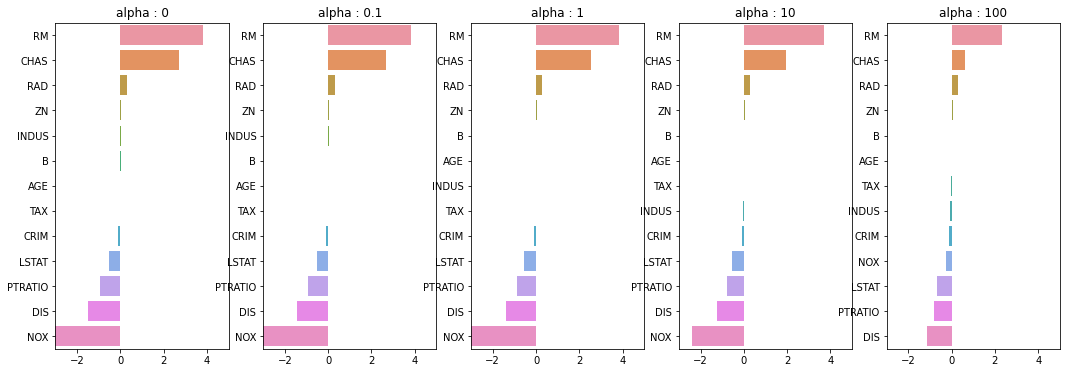

,alpha : 0,alpha : 0.1,alpha : 1,alpha : 10,alpha : 100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston

boston=load_boston()
bostonDF=pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE']=boston.target

from sklearn.model_selection import train_test_split

y_target=bostonDF['PRICE']
X_data=bostonDF.drop('PRICE', axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_data, y_target, test_size=0.3, random_state=156)

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge=Ridge(alpha=10)
neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 Folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 3))
print('5 Folds 의 개별 RMSE scores : ', np.round(rmse_scores, 3))
print('5 Folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

alphas=[0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge=Ridge(alpha=alpha)

    neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

fig, axs=plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
coeff_df=pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    coeff=pd.Series(data=ridge.coef_, index=X_data.columns)
    colname='alpha : '+str(alpha)
    coeff_df[colname]=coeff
    coeff=coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 5)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

ridge_alphas=[0, 0.1, 10, 100]
sort_column='alpha : '+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

In [2]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    
    coeff_df=pd.DataFrame()
    
    if verbose : print('######', model_name, '######')
    
    for param in params:
        if model_name=='Ridge' : model=Ridge(alpha=param)
        elif model_name=='Lasso' : model=Lasso(alpha=param)
        elif model_name=='ElasticNet' : model=ElasticNet(alpha=param, l1_ratio=0.7)
    
        neg_mse_scores=cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0} 일 때, 5폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
    
        model.fit(X_data_n, y_target_n)
    
        if return_coeff:
            coeff=pd.Series(data=model.coef_, index=X_data_n.columns)
            colname='alpha : '+str(param)
    
            coeff_df[colname]=coeff
    return coeff_df

lasso_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df=get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data,y_target_n=y_target)
sort_column='alpha : '+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

elastic_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df=get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method='None', p_degree=None, input_data=None):
    
    if method=='Standard':
        scaled_data=StandardScaler().fit_transform(input_data)
    elif method=='MinMax':
        scaled_data=MinMaxScaler().fit_transform(input_data)
    elif method=='Log':
        scaled_data=np.log1p(input_data)
    else:
        scaled_data=input_data
    
    if p_degree != None:
        scaled_data=PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data

alphas=[0.1, 1, 10, 100]

scale_methods=[(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled=get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형 : {0}, Polynomial Degree : {1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False)

###### Lasso ######
alpha 0.07 일 때, 5폴드 세트의 평균 RMSE : 5.612
alpha 0.1 일 때, 5폴드 세트의 평균 RMSE : 5.615
alpha 0.5 일 때, 5폴드 세트의 평균 RMSE : 5.669
alpha 1 일 때, 5폴드 세트의 평균 RMSE : 5.776
alpha 3 일 때, 5폴드 세트의 평균 RMSE : 6.189
###### ElasticNet ######
alpha 0.07 일 때, 5폴드 세트의 평균 RMSE : 5.542
alpha 0.1 일 때, 5폴드 세트의 평균 RMSE : 5.526
alpha 0.5 일 때, 5폴드 세트의 평균 RMSE : 5.467
alpha 1 일 때, 5폴드 세트의 평균 RMSE : 5.597
alpha 3 일 때, 5폴드 세트의 평균 RMSE : 6.068
(506, 13) (506, 13)

## 변환 유형 : None, Polynomial Degree : None
alpha 0.1 일 때, 5폴드 세트의 평균 RMSE : 5.788
alpha 1 일 때, 5폴드 세트의 평균 RMSE : 5.653
alpha 10 일 때, 5폴드 세트의 평균 RMSE : 5.518
alpha 100 일 때, 5폴드 세트의 평균 RMSE : 5.330
(506, 13) (506, 13)

## 변환 유형 : Standard, Polynomial Degree : None
alpha 0.1 일 때, 5폴드 세트의 평균 RMSE : 5.826
alpha 1 일 때, 5폴드 세트의 평균 RMSE : 5.803
alpha 10 일 때, 5폴드 세트의 평균 RMSE : 5.637
alpha 100 일 때, 5폴드 세트의 평균 RMSE : 5.421
(506, 104) (506, 13)

## 변환 유형 : Standard, Polynomial Degree : 2
alpha 0.1 일 때, 5폴드 세트의 평균 RMSE : 8.827
alpha 1 일 때, 5폴드 세트의 평균 RMSE : 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer=load_breast_cancer()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler=StandardScaler()
data_scaled=scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test=train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds=lr_clf.predict(X_test)
print('accuracy : {0:.3f}'.format(accuracy_score(y_test, lr_preds)))

accuracy : 0.977


In [ ]:
from sklearn.model_selection import GridSearchCV

params={'penalty' : ['12', '11'], 'C':[0.01, 0.1, 1, 1, 5, 10]}
grid_clf=GridSearchCV(lr_clf, param_grid=params, scoring='accuracy',cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터 : {0}, 최적 평균 정확도 : {1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

In [13]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

boston=load_boston()
bostonDF=pd.DataFrame(boston.data, columns=boston.feature_names)

bostonDF['PRICE']=boston.target
y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

rf=RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores=cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))


5 교차 검증의 개별 Negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [14]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores=cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores=np.sqrt(-1*neg_mse_scores)
    avg_rmse=np.mean(rmse_scores)
    print('####', model.__class__.__name__, '####')
    print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg=DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg=RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg=GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg=XGBRegressor(n_estimators=1000)
lgb_reg=LGBMRegressor(n_estimators=1000)

models=[dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

#### DecisionTreeRegressor ####
5 교차 검증의 평균 RMSE : 5.978
#### RandomForestRegressor ####
5 교차 검증의 평균 RMSE : 4.423
#### GradientBoostingRegressor ####
5 교차 검증의 평균 RMSE : 4.269
#### XGBRegressor ####
5 교차 검증의 평균 RMSE : 4.251
#### LGBMRegressor ####
5 교차 검증의 평균 RMSE : 4.646


<AxesSubplot:>

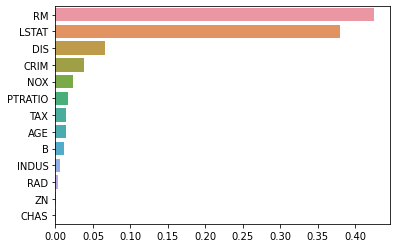

In [16]:
rf_reg=RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_data, y_target)

feature_series=pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series=feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


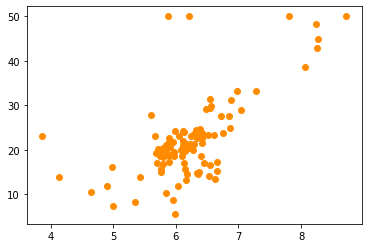

In [17]:
bostonDF_sample=bostonDF[['RM','PRICE']]
bostonDF_sample=bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

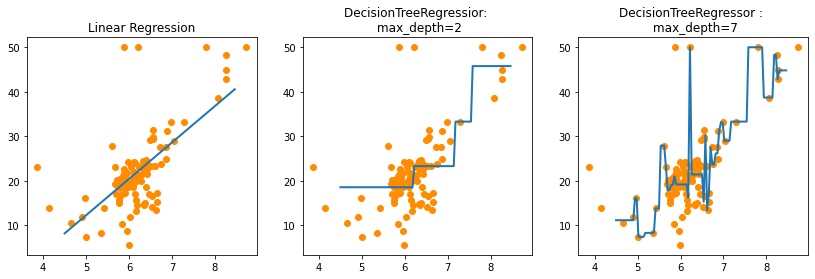

In [18]:
from sklearn.linear_model import LinearRegression

lr_reg=LinearRegression()
rf_Reg2=DecisionTreeRegressor(max_depth=2)
rf_Reg7=DecisionTreeRegressor(max_depth=7)

X_test=np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

X_feature=bostonDF_sample['RM'].values.reshape(-1, 1)
y_target=bostonDF_sample['PRICE'].values.reshape(-1, 1)

lr_reg.fit(X_feature, y_target)
rf_Reg2.fit(X_feature, y_target)
rf_Reg7.fit(X_feature, y_target)

pred_lr=lr_reg.predict(X_test)
pred_rf2=rf_Reg2.predict(X_test)
pred_rf7=rf_Reg7.predict(X_test)

fig, (ax1, ax2, ax3)=plt.subplots(figsize=(14, 4), ncols=3)

ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

ax2.set_title('DecisionTreeRegressior: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth : 3', linewidth=2)

ax3.set_title('DecisionTreeRegressor : \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth : 7', linewidth=2)

In [33]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df=pd.read_csv('./bike_train.csv')
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)
bike_df['year']=bike_df.datetime.apply(lambda x: x.year)
bike_df['month']=bike_df.datetime.apply(lambda x: x.month)
bike_df['day']=bike_df.datetime.apply(lambda x: x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x: x.hour)

drop_coulmns=['datetime','casual','registered']
bike_df.drop(drop_coulmns, axis=1, inplace=True)

from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val=rmsle(y, pred)
    rmse_val=rmse(y, pred)
    mae_val=mean_absolute_error(y, pred)
    print('RMSLE : {0:.3f}, RMSE : {1:.3f}, MAE : {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

In [34]:
y_target=bike_df['count']
X_features=bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE : 140.900, MAE : 105.924


In [35]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df=pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<AxesSubplot:>

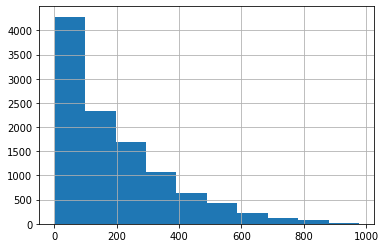

In [36]:
y_target.hist()

<AxesSubplot:>

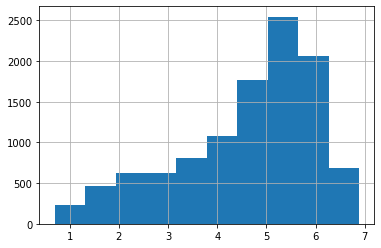

In [37]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [40]:
y_target_log=np.log1p(y_target)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

y_test_exp=np.expm1(y_test)
pred_exp=np.expm1(pred)

pred_exp=np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE : 162.594, MAE : 109.286


<AxesSubplot:>

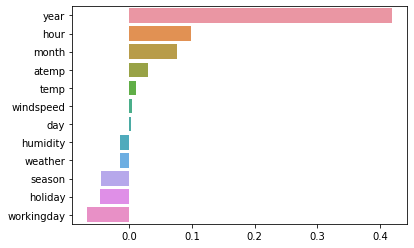

In [41]:
coef=pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [45]:
X_features_ohe=pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

X_train, X_test, y_train, y_test=train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)

lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True )

### LinearRegression ###
RMSLE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSLE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSLE : 0.635, RMSE : 113.219, MAE : 72.803


<AxesSubplot:>

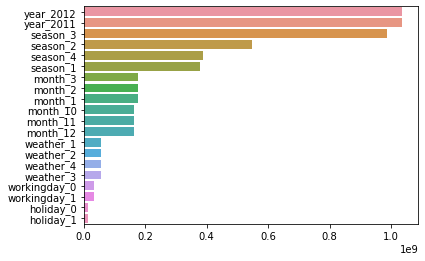

In [47]:
coef=pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [50]:
rf_reg=RandomForestRegressor(n_estimators=500)
gbm_reg=GradientBoostingRegressor(n_estimators=500)
xgb_reg=XGBRegressor(n_estimators=500)
lgbm_reg=LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE : 0.354, RMSE : 50.413, MAE : 31.148
### GradientBoostingRegressor ###
RMSLE : 0.330, RMSE : 53.330, MAE : 32.736
### XGBRegressor ###
RMSLE : 0.342, RMSE : 51.732, MAE : 31.251
### LGBMRegressor ###
RMSLE : 0.319, RMSE : 47.215, MAE : 29.029


<AxesSubplot:title={'center':'Origial Sale Price HIstogram'}, xlabel='SalePrice', ylabel='Density'>

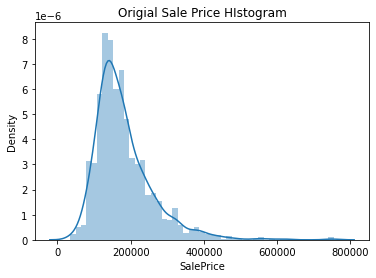

In [62]:
house_df_org=pd.read_csv('./house_price.csv')
house_df=house_df_org.copy()

plt.title('Origial Sale Price HIstogram')
sns.distplot(house_df['SalePrice'])

<AxesSubplot:title={'center':'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

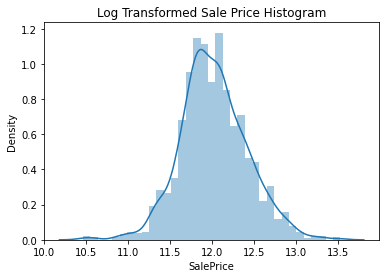

In [63]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [64]:
original_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)
house_df.fillna(house_df.mean(), inplace=True)

null_column_count=house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## NUll 값 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## NUll 값 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [65]:
print('get_dummies() 수행 전 데이터 Shape : ', house_df.shape)
house_df_ohe=pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape : ', house_df_ohe.shape)

null_column_count=house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('### Null 피처의 Type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape :  (1460, 75)
get_dummies() 수행 후 데이터 Shape :  (1460, 271)
### Null 피처의 Type: 
 Series([], dtype: object)


In [76]:
def get_rmse(model):
    pred=model.predict(X_test)
    mse=mean_squared_error(y_test, pred)
    rmse=np.sqrt(mse)
    print('{0} 로그 변환된 RMSE : {1}'.format(model.__class__.__name__, np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse=get_rmse(model)
        rmses.append(rmse)
    return rmses

In [77]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=150)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg=Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg=Lasso()
lasso_reg.fit(X_train, y_train)

models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE : 0.122
Ridge 로그 변환된 RMSE : 0.125
Lasso 로그 변환된 RMSE : 0.198


[0.12174419924286886, 0.1251239533448504, 0.19842900605042285]

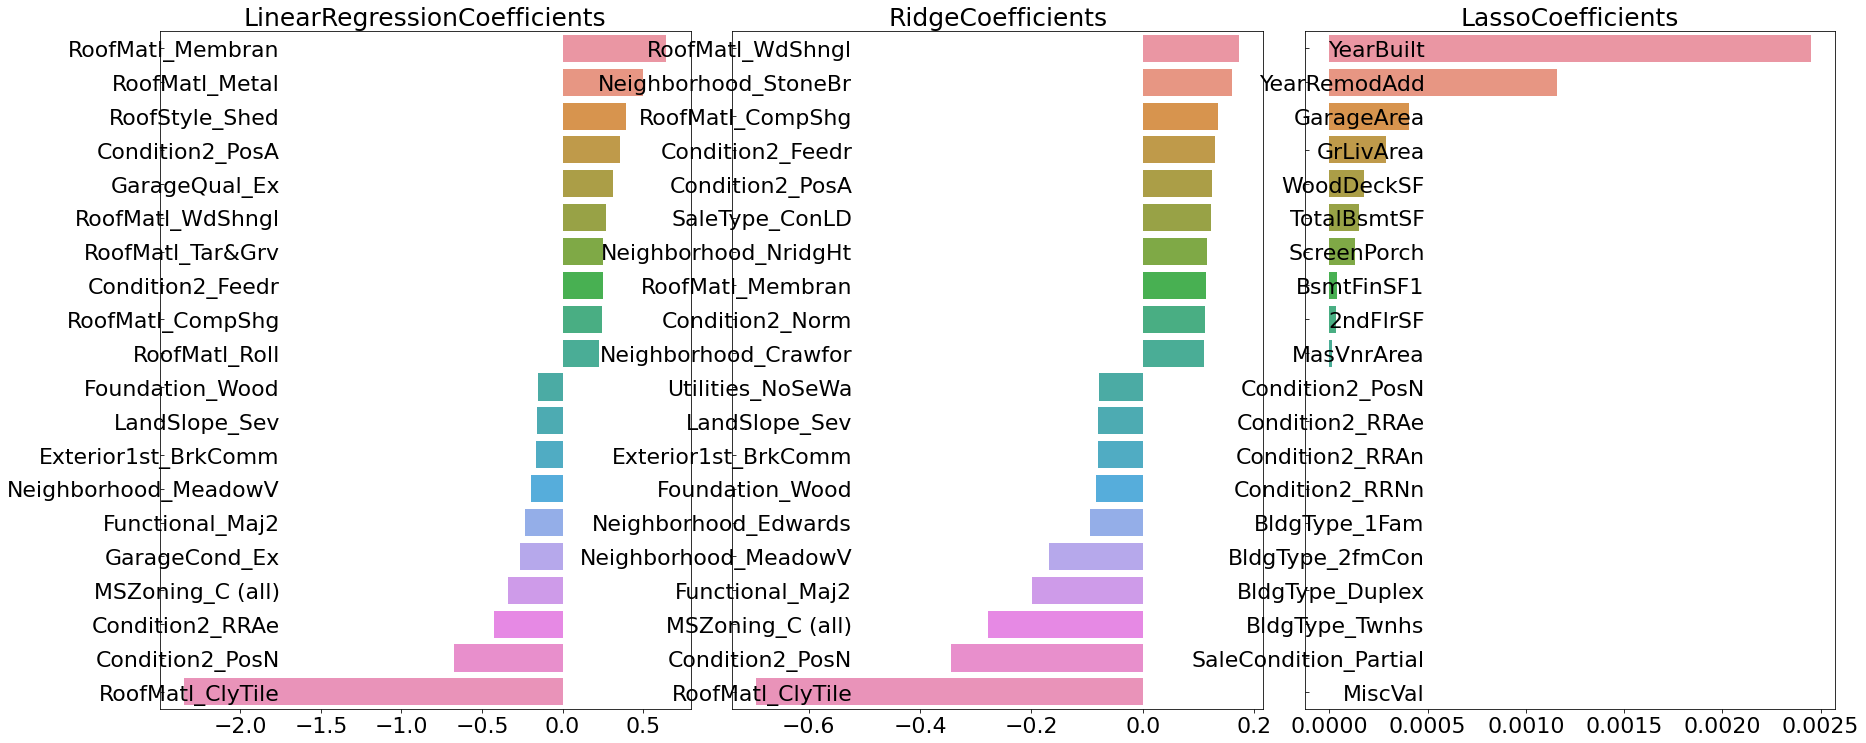

In [80]:
def get_top_bottom_coef(model):
    coef=pd.Series(model.coef_, index=X_features.columns)
    coef_high=coef.sort_values(ascending=False).head(10)
    coef_low=coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

def visualize_coefficients(models):
    fig, axs=plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        coef_high, coef_low=get_top_bottom_coef(model)
        coef_concat=pd.concat([coef_high, coef_low])
        axs[i_num].set_title(model.__class__.__name__ + 'Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficients(models)

In [81]:
def get_avg_rmse_cv(models):
    for model in models:
        rmse_list=np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg=np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models=[lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 : [  nan 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값 : nan

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 : 0.198


In [83]:
def print_best_params(model, params):
    grid_model=GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

    return grid_model.best_estimator_

ridge_params={'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge=print_best_params(ridge_reg, ridge_params)
best_lasso=print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha {'alpha': 0.001}


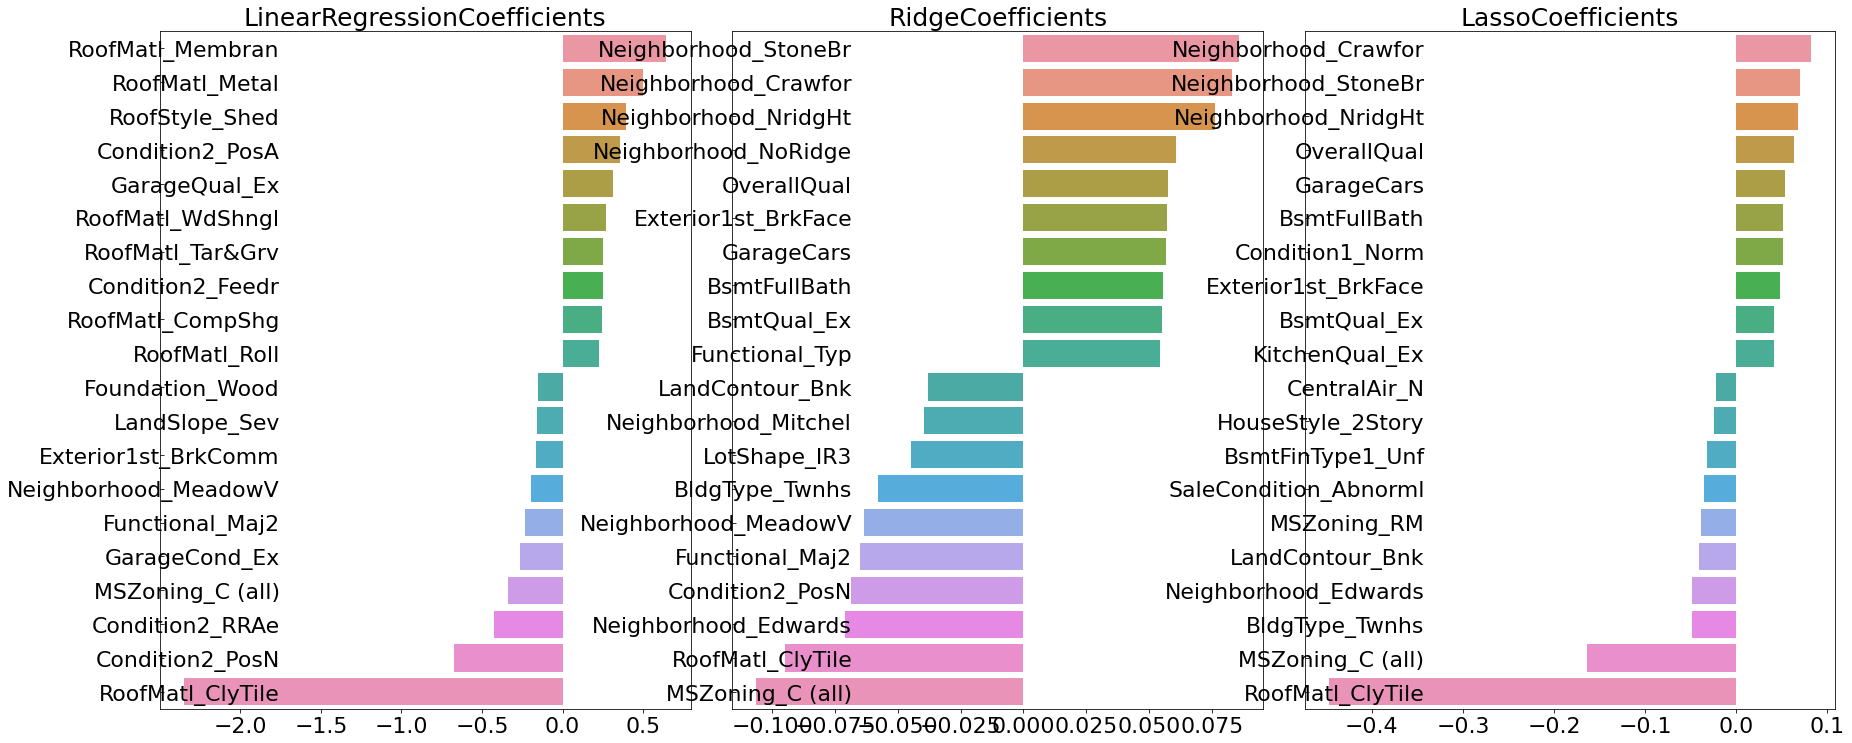

In [84]:
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models=[lr_reg, ridge_reg, lasso_reg]
visualize_coefficients(models)

In [86]:
from scipy.stats import skew

features_index=house_df.dtypes[house_df.dtypes != 'object'].index
skew_features=house_df[features_index].apply(lambda x:skew(x))
skew_features_top=skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [87]:
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

In [92]:
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params={'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge=print_best_params(ridge_reg, ridge_params)
best_lasso=print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.128
Ridge 로그 변환된 RMSE : 0.122
Lasso 로그 변환된 RMSE : 0.119


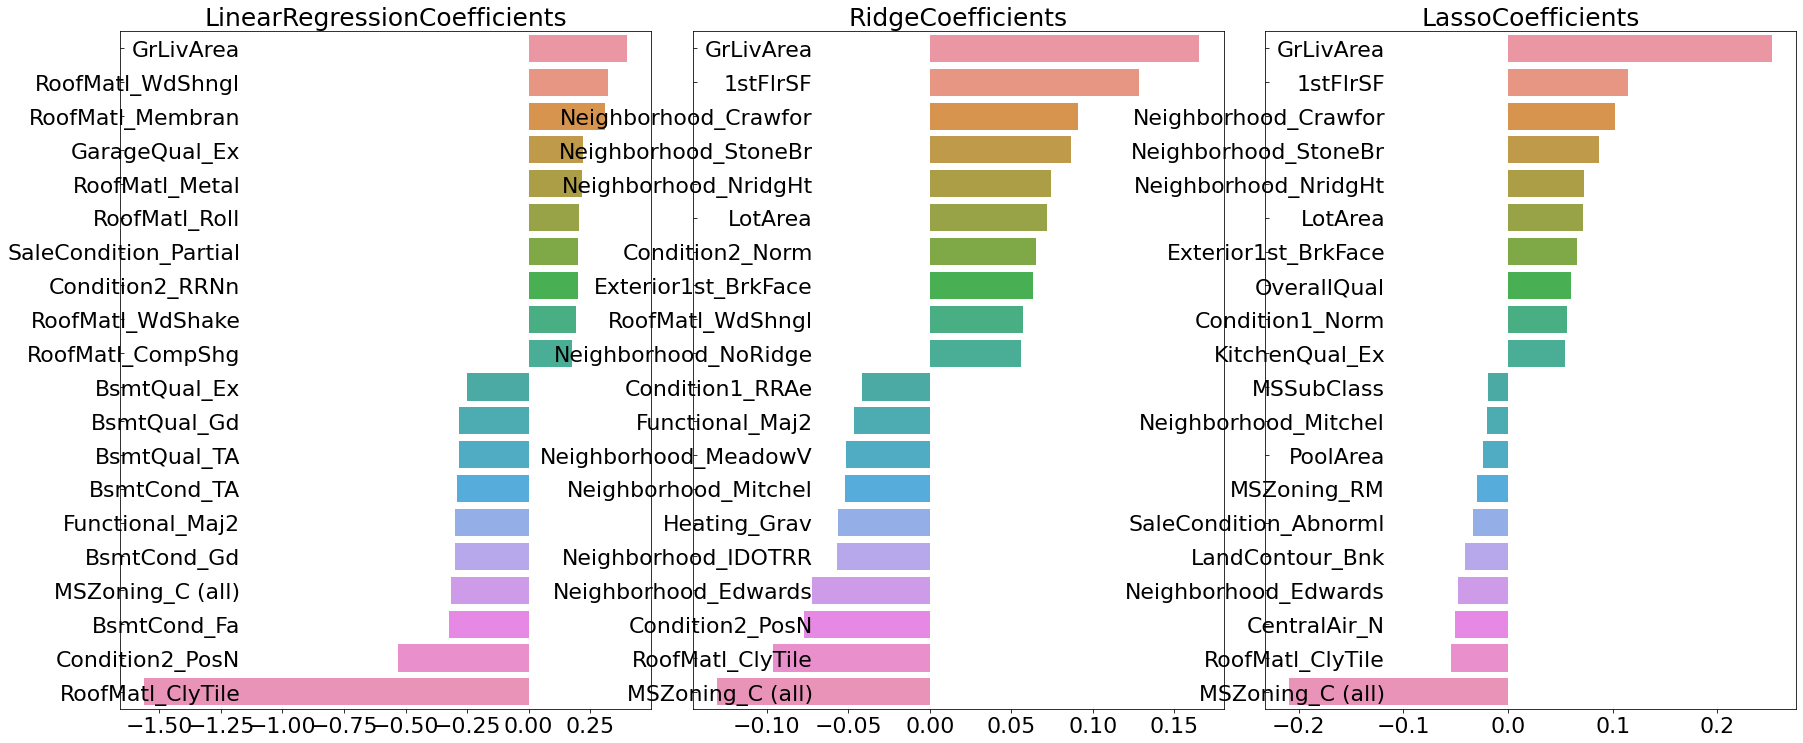

In [93]:
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)


models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficients(models)

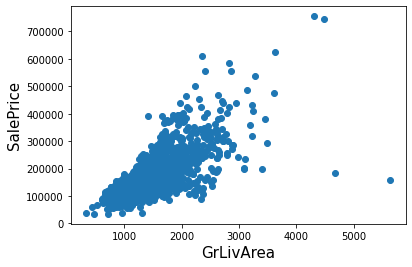

In [94]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [97]:
cond1=house_df_ohe['GrLivArea']>np.log1p(4000)
cond2=house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index=house_df_ohe[cond1&cond2].index

print('아웃라이어 레코드 index : ', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe.shpae : ', house_df_ohe.shape)
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe.shape : ', house_df_ohe.shape)

아웃라이어 레코드 index :  [ 523 1298]
아웃라이어 삭제 전 house_df_ohe.shpae :  (1460, 271)
아웃라이어 삭제 후 house_df_ohe.shape :  (1458, 271)


In [98]:
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop(['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params={'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1.5, 10]}
best_ridge=print_best_params(ridge_reg, ridge_params)
best_lasso=print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE : 0.129
Ridge 로그 변환된 RMSE : 0.103
Lasso 로그 변환된 RMSE : 0.1


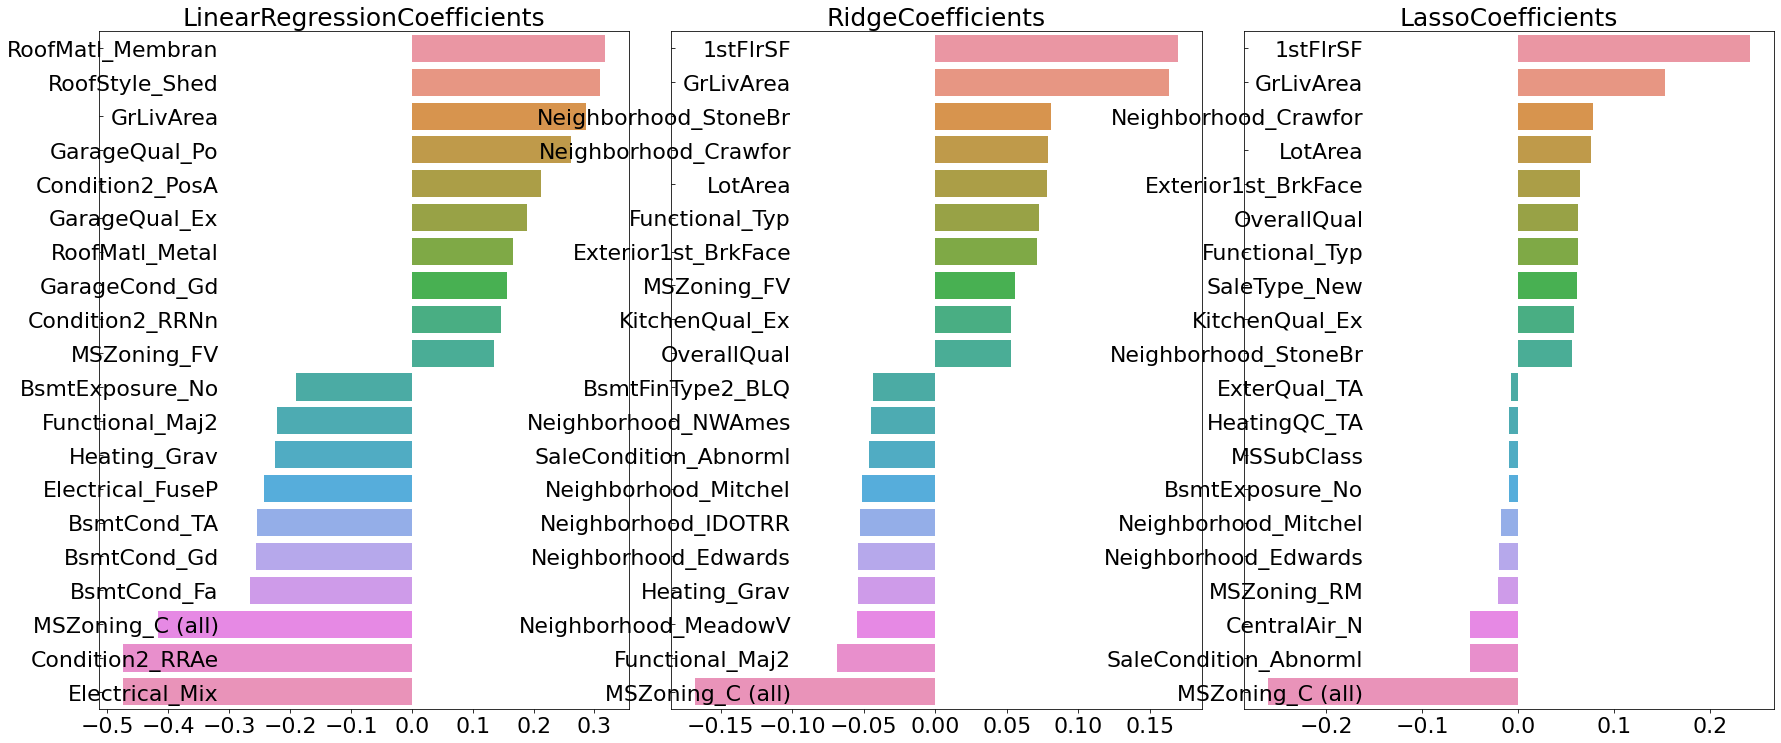

In [99]:
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg=Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)


models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficients(models)

In [100]:
from xgboost import XGBRegressor

xgb_params={'n_estimators' : [1000]}
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
best_xgb=print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1178, 최적 alpha {'n_estimators': 1000}


In [101]:
from lightgbm import LGBMRegressor

lgbm_params={'n_estimators' : [1000]}
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)
best_lgb=print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1163, 최적 alpha {'n_estimators': 1000}


In [117]:
def get_top_features(model):
    ftr_importances_values=model.feature_importances_
    ftr_importances=pd.Series(ftr_importances_values, index=X_features.columns)
    ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importance(models):
    fig, axs=plt.subplots(figsize=(24, 10), nrows=1, ncols=2)
    fig.tight_layout()
    for i_num, model in enumerate(models):
        ftr_top20=get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__ + 'Feature Importances', size=25)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index, ax=axs[i_num])

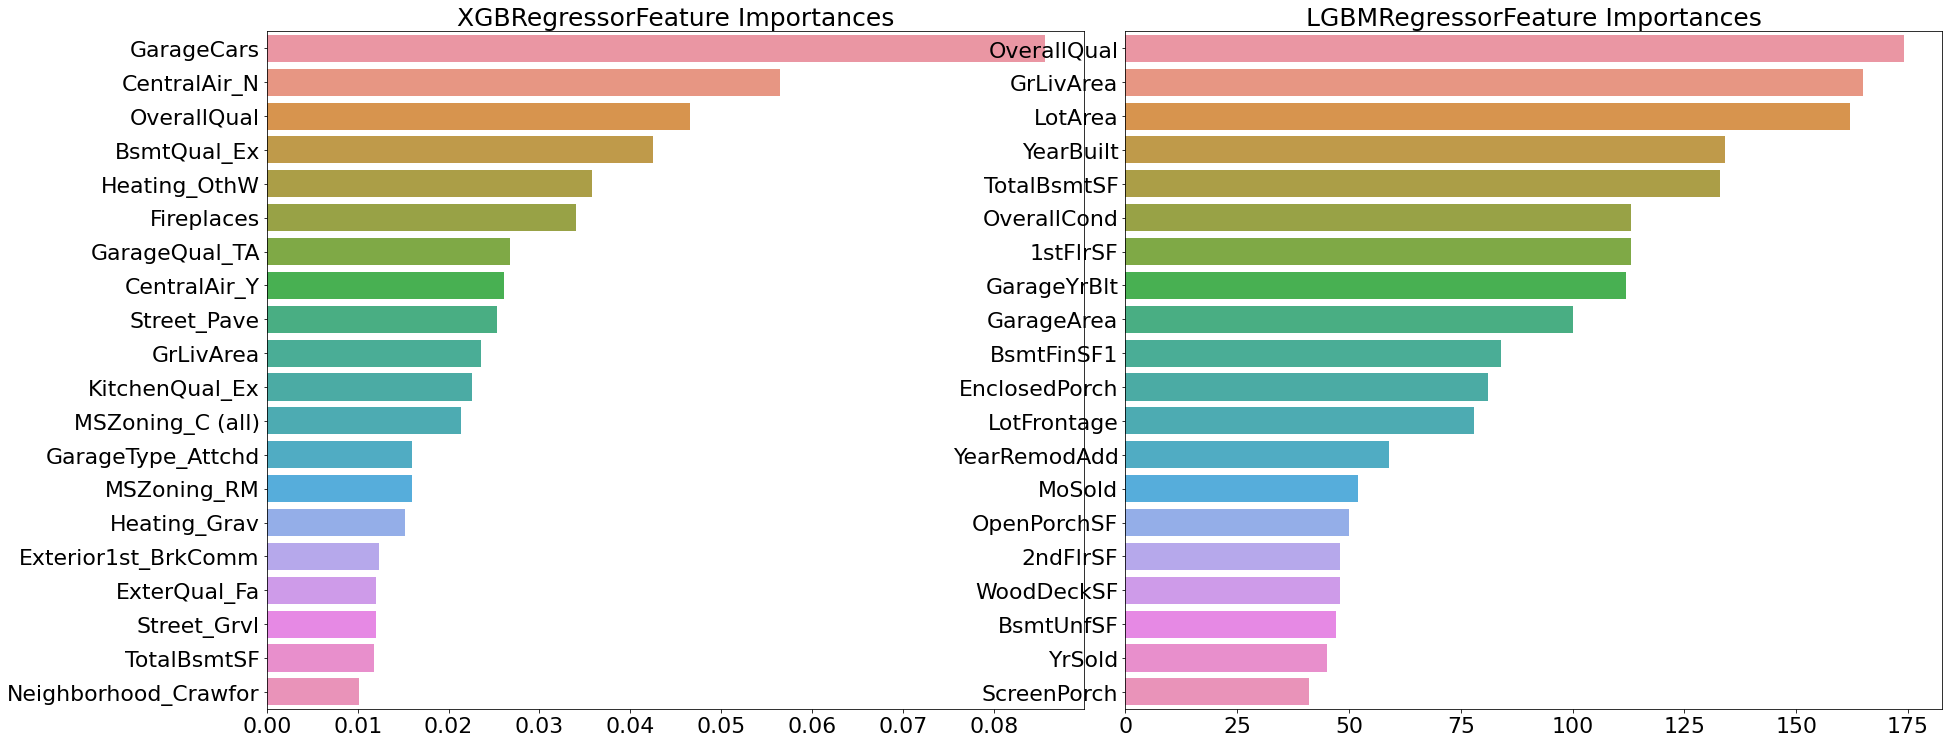

In [118]:
models=[best_xgb, best_lgbm]
visualize_ftr_importance(models)

In [120]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value=preds[key]
        mse=mean_squared_error(y_test, pred_value)
        rmse=np.sqrt(mse)
        print('{0} 모델의 RMSE : {1}'.format(key, rmse))

ridge_reg=Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg=Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

ridge_pred=ridge_reg.predict(X_test)
lasso_pred=lasso_reg.predict(X_test)

pred=0.4*ridge_pred+0.6*lasso_pred
preds={'최종 혼합':pred, 'Ridge':ridge_pred, 'Lasso':lasso_pred}
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10007930884470488
Ridge 모델의 RMSE : 0.10345177546603207
Lasso 모델의 RMSE : 0.10024170460890024


In [122]:
xgb_reg=XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg=LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)

xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred=xgb_reg.predict(X_test)
lgbm_pred=lgbm_reg.predict(X_test)

pred=0.5*xgb_pred+0.5*lgbm_pred
preds={'최종 혼합' : pred, 'XGBM' : xgb_pred, 'LGBM' : lgbm_pred}
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10170077353447762
XGBM 모델의 RMSE : 0.10738295638346222
LGBM 모델의 RMSE : 0.10382510019327311


In [132]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf=KFold(n_splits=n_folds, shuffle=False)
    train_fold_pred=np.zeros((X_train_n.shape[0], 1))
    test_pred=np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트 : ', folder_counter, '시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]

        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter]=model.predict(X_test_n)

    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1, 1)
    return train_fold_pred, test_pred_mean

In [133]:
X_train_n=X_train.values
X_test_n=X_test.values
y_train_n=y_train.values

ridge_train, ridge_test=get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test=get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test=get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test=get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)


Ridge model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
Lasso model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
XGBRegressor model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작
LGBMRegressor model 시작
	 폴드 세트 :  0 시작
	 폴드 세트 :  1 시작
	 폴드 세트 :  2 시작
	 폴드 세트 :  3 시작
	 폴드 세트 :  4 시작


In [135]:
Stack_final_X_train=np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test=np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta_model_lasso=Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final=meta_model_lasso.predict(Stack_final_X_test)
mse=mean_squared_error(y_test, final)
rmse=np.sqrt(mse)

print('스태킹 휘귀 모델의 최종 RMSE 값은 : ', rmse)

스태킹 휘귀 모델의 최종 RMSE 값은 :  0.09799152965189696
